In [1]:
import librosa
import librosa.feature
import numpy as np

In [2]:
x, sr = librosa.load('data/i.wav', sr=None)

In [3]:
sr

16000

In [4]:
x.shape

(20000,)

In [5]:
librosa.get_duration(y=x, sr=sr)

1.25

In [6]:
hop_length = 15
frame_length = 30

In [7]:
energy = np.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

In [8]:
energy.shape

(1334,)

# 1. Sử dụng RMSE

In [9]:
rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length, center=True)


In [10]:
rmse.shape

(1, 1334)

In [11]:
rmse = rmse[0]

In [12]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

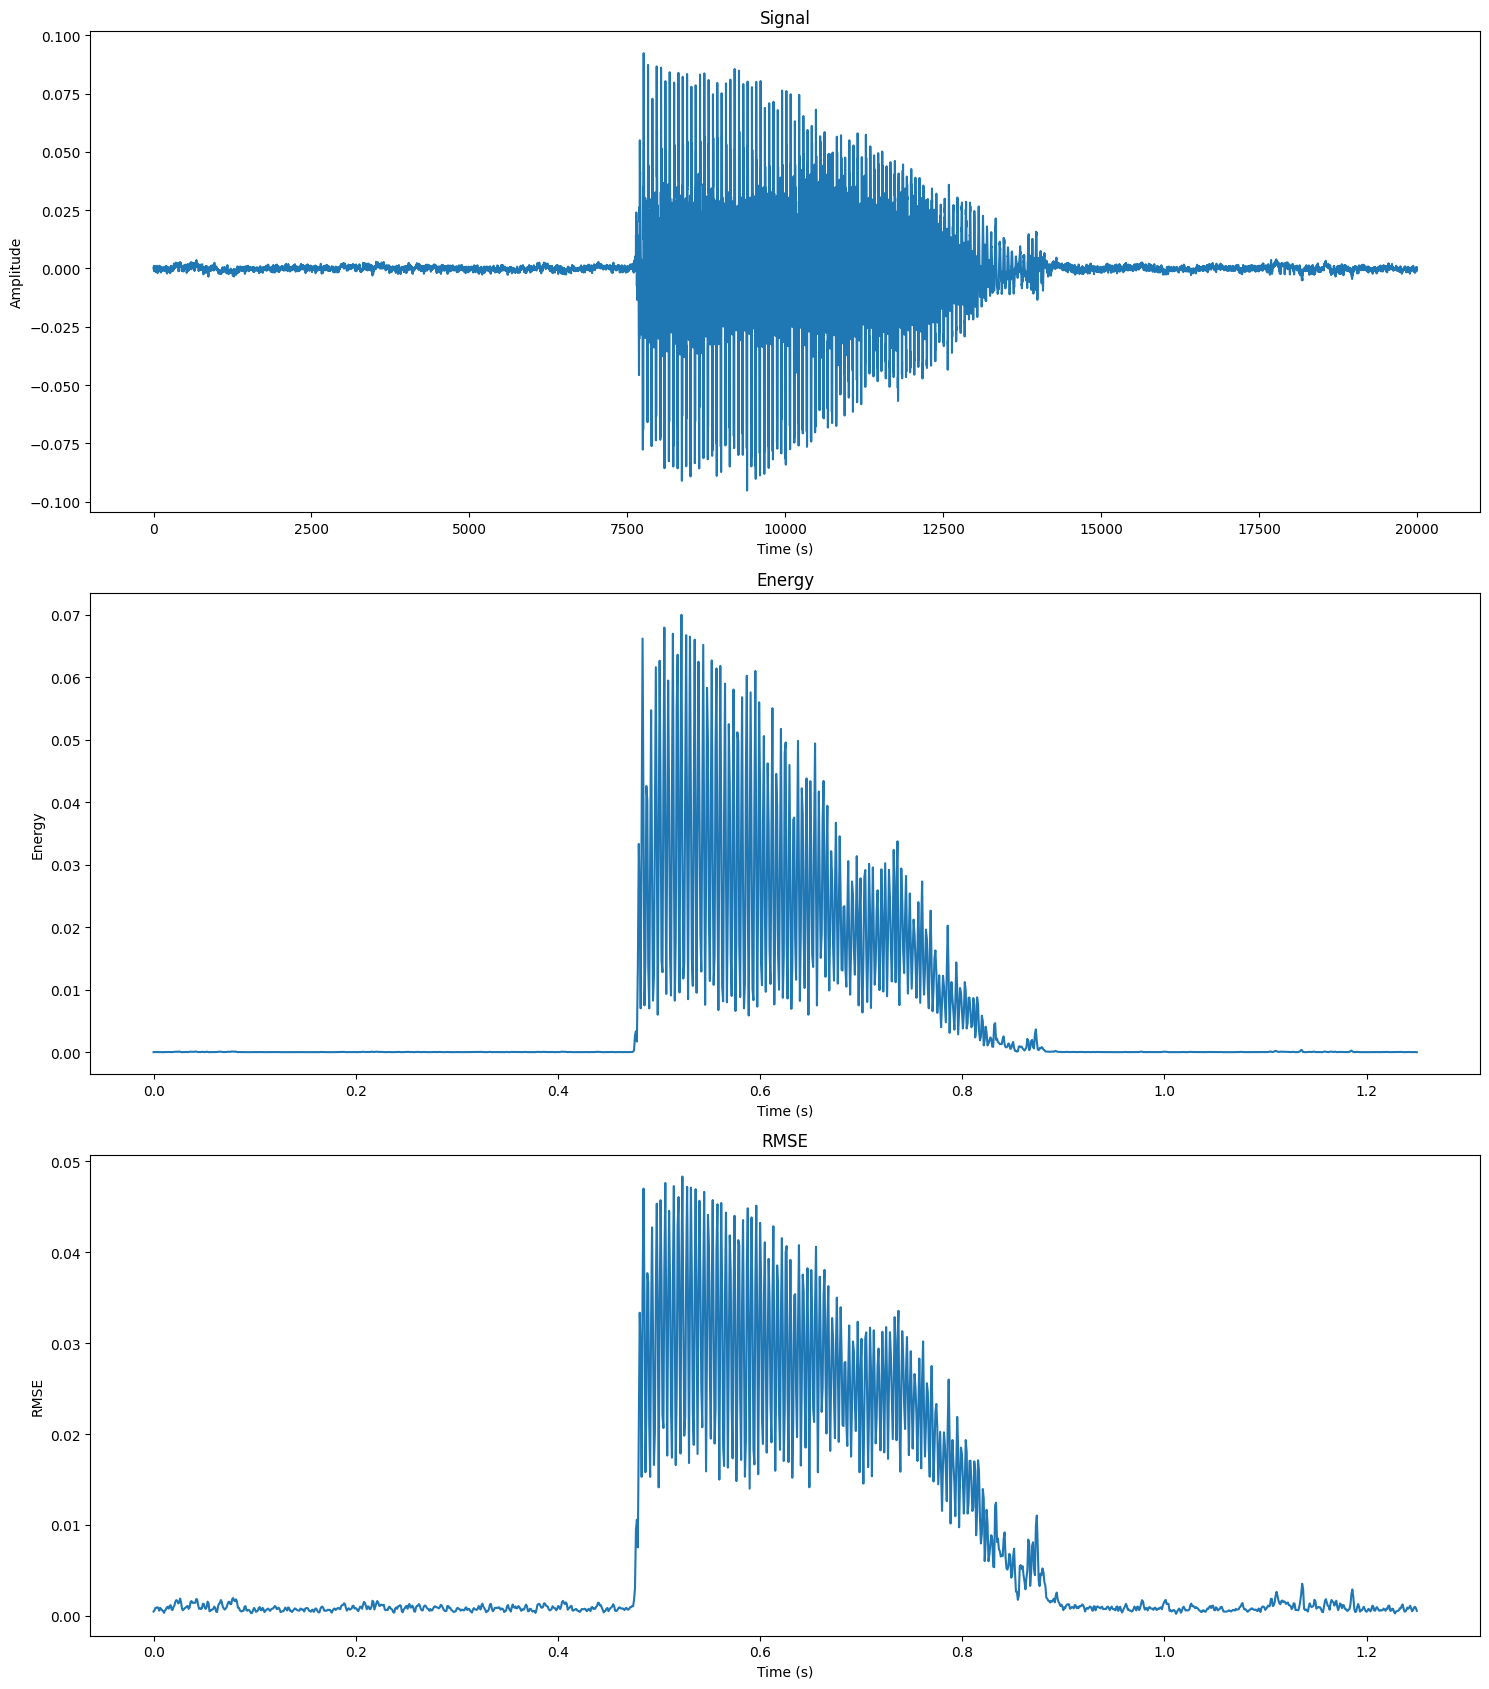

In [13]:
# Plot the signal
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
plt.plot(x)
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(t, energy)
plt.title('Energy')
plt.xlabel('Time (s)')
plt.ylabel('Energy')

plt.subplot(3, 1, 3)
plt.plot(t, rmse)
plt.title('RMSE')
plt.xlabel('Time (s)')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()


In [14]:
def strip(x, frame_length, hop_length):

    # Tính RMSE
    rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length, center=True)

    # Đặt ngưỡng RMSE
    thresh = 0.005

    # Tạo danh sách các frame mà RMSE >= ngưỡng
    valid_frames = np.where(rmse[0] >= thresh)[0]

    # Nếu không có frame nào thỏa mãn, trả về mảng trống
    if len(valid_frames) == 0:
        return []

    # Tính các chỉ số sample tương ứng với các frame đầu và cuối hợp lệ
    start_sample_index = librosa.frames_to_samples(valid_frames[0], hop_length=hop_length)
    end_sample_index = librosa.frames_to_samples(valid_frames[-1] + 1, hop_length=hop_length)

    # Trả về đoạn âm thanh sau khi loại bỏ các frame không hợp lệ
    return x[start_sample_index:end_sample_index]

In [15]:
y = strip(x, frame_length, hop_length)

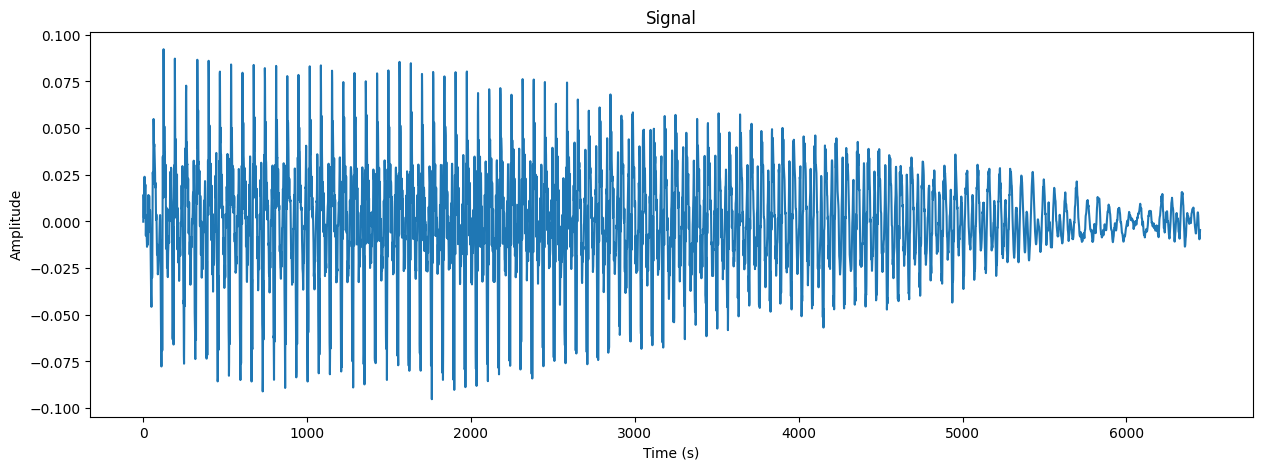

In [16]:
# plot the trimmed signal
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# 2. Chuẩn hóa năng lượng

In [17]:
energy_nomalized = energy / np.max(energy)

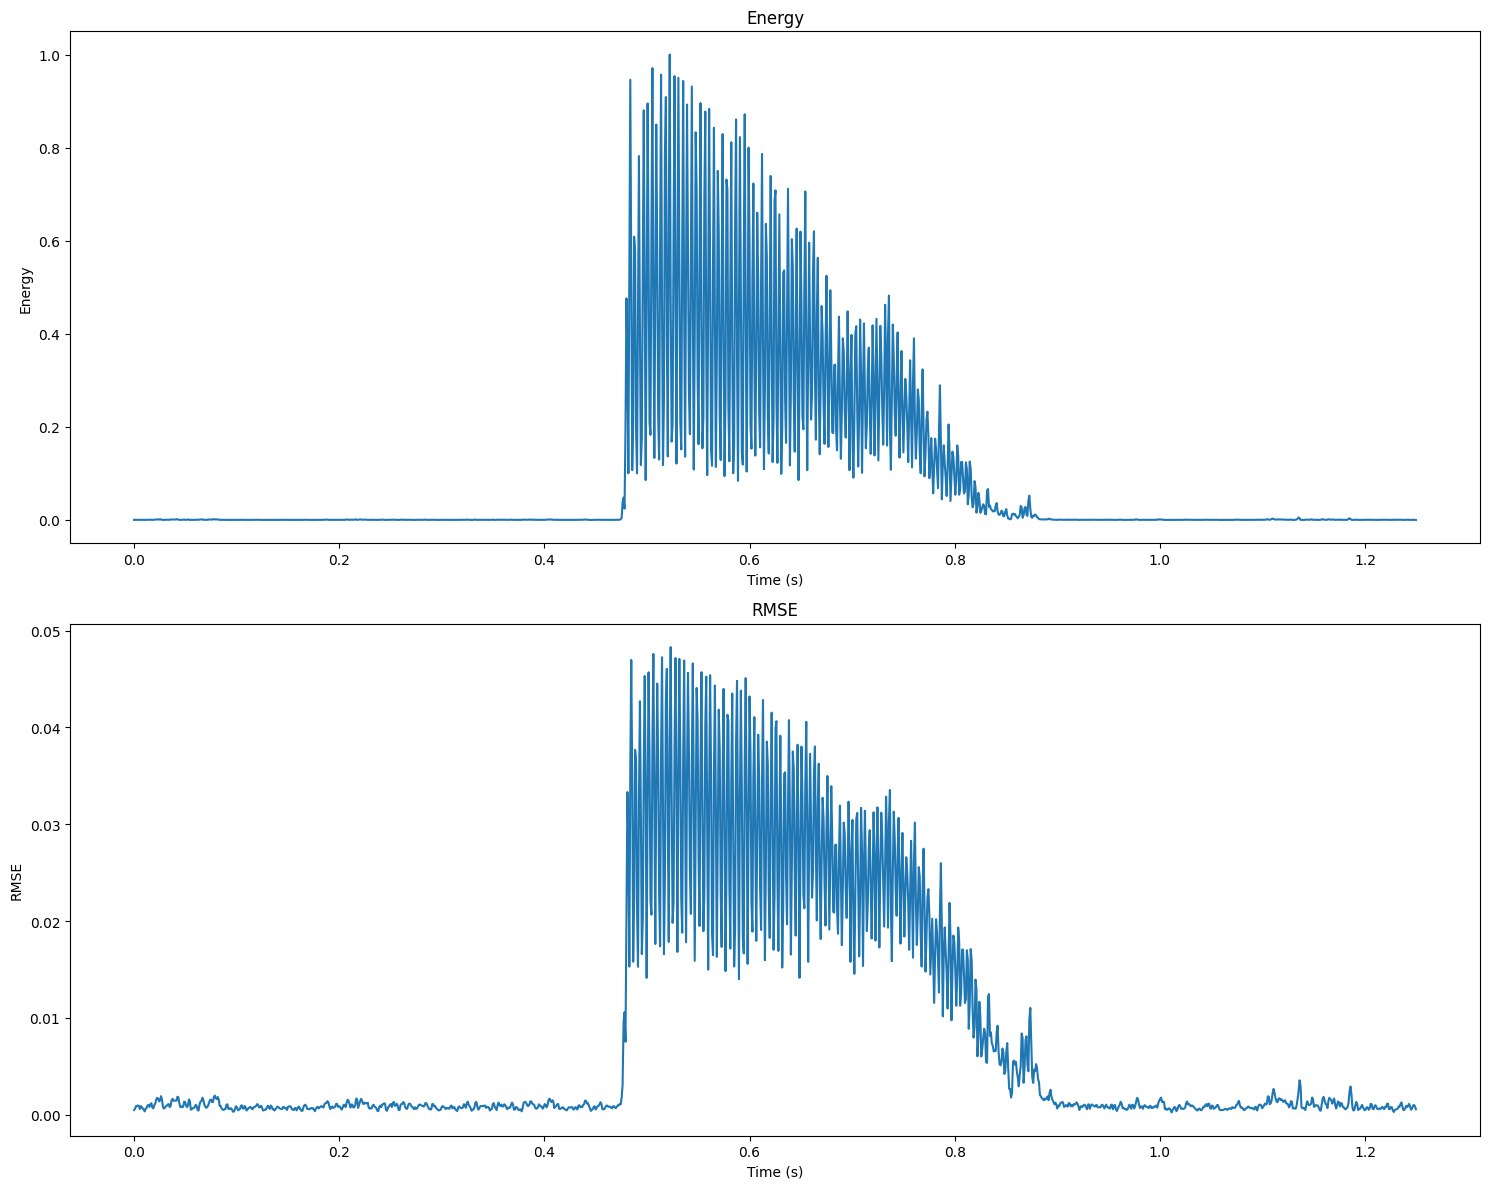

In [21]:
# plot the signal
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
plt.plot(t, energy_nomalized)
plt.title('Energy')
plt.xlabel('Time (s)')
plt.ylabel('Energy')

plt.subplot(2, 1, 2)
plt.plot(t, rmse)
plt.title('RMSE')
plt.xlabel('Time (s)')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()